In [11]:
import os
import numpy as np
import seaborn as sns
from pymbar import BAR
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from glob import glob
import pickle
from simtk.openmm import unit
import bz2
from beryllium import plotting, stats
import pandas as pd
import json
import tqdm
from openmmtools.constants import kB
import networkx as nx
import random
temperature = 300.0 * unit.kelvin
kT = kB * temperature

In [2]:
def form_edge_matrix(g, label, step=None, action=None):
    """
    Extract the labeled property from edges into a matrix

    Parameters
    ----------
    g : nx.Graph
        The graph to extract data from
    label : str
        The label to use for extracting edge properties
    action : str, optional, default=None
        If 'symmetrize', will return a symmetric matrix where A[i,j] = A[j,i]
        If 'antisymmetrize', will return an antisymmetric matrix where A[i,j] = -A[j,i]

    """
    N = len(g.nodes)
    matrix = np.zeros([N,N])
    node_index_map = {j:i for i, j in enumerate(g.nodes)}

    for i, j in g.edges:
        m, n = node_index_map[i],node_index_map[j]        
        matrix[m,n] = g.edges[i,j][label]
        if action == 'symmetrize':
            matrix[n,m] = matrix[m,n]
        elif action == 'antisymmetrize':
            matrix[n,m] = - matrix[m,n]
        elif action is None:
            pass
        else:
            raise Exception(f'action "{action}" unknown.')
    return matrix


def mle(g,factor='f_ij'):
    """
    Compute maximum likelihood estimate of free energies and covariance in their estimates.
    The number 'factor' is the node attribute on which the MLE will be calculated,
    where d'factor' will be used as the standard error of the factor

    We assume the free energy of node 0 is zero.

    Reference : https://pubs.acs.org/doi/abs/10.1021/acs.jcim.9b00528
    Xu, Huafeng. "Optimal measurement network of pairwise differences." Journal of Chemical Information and Modeling 59.11 (2019): 4720-4728.

    Parameters
    ----------
    g : nx.Graph
        The graph for which an estimate is to be computed
        Each edge must have attributes 'f_ij' and 'df_ij' for the free energy and uncertainty estimate
        Will have 'bayesian_f_ij' and 'bayesian_df_ij' added to each edge
        and 'bayesian_f_i' and 'bayesian_df_i' added to each node.
    factor : string, default = 'f_ij'
        node attribute of nx.Graph that will be used for MLE
    Returns
    -------
    f_i : np.array with shape (n_ligands,)
        f_i[i] is the absolute free energy of ligand i in kT
        f_i[0] = 0

    C : np.array with shape (n_ligands, n_ligands)
        C[i,j] is the covariance of the free energy estimates of i and j

    """
    N = len(g.nodes)
    
    # number of nodes may not be the same as the indices of the nodes
    node_index_map = {j:i for i, j in enumerate(g.nodes)}
    
    f_ij = form_edge_matrix(g, factor, action='antisymmetrize')
    df_ij = form_edge_matrix(g, factor.replace('_','_d'), action='symmetrize')

    # Form F matrix (Eq 4)
    F = np.zeros([N,N])
    for (i,j) in g.edges:
        m, n = node_index_map[i], node_index_map[j]
        F[m,n] = - df_ij[m,n]**(-2)
        F[n,m] = - df_ij[m,n]**(-2)
    for i in g.nodes:
        m = node_index_map[i]
        F[m,m] = - np.sum(F[m,:])

    # Form z vector (Eq 3)
    z = np.zeros([N])
    for (i,j) in g.edges:
        m, n = node_index_map[i], node_index_map[j]
        z[m] += f_ij[m,n] * df_ij[m,n]**(-2)
        z[n] += f_ij[n,m] * df_ij[n,m]**(-2)

    # Compute MLE estimate (Eq 2)
    Finv = np.linalg.pinv(F)
    f_i = - np.matmul(Finv, z) # NOTE: This differs in sign from Eq. 2!
    f_i[:] -= f_i[0]

    # Compute uncertainty
    C = Finv
    return f_i, C

In [3]:
with bz2.BZ2File('../data/work-13420.pkl.bz2', 'r') as infile:
    work = pickle.load(infile)

In [4]:
work.replace([np.inf, -np.inf], np.nan)
work = work.dropna()

def _strip_outliers(w,n_devs=100):
    w = [x for x in w if np.abs(x) < 10**4]
    mean = np.mean(w)
    std = np.std(w)
    good_w = [x for x in w if np.abs(x-mean) < n_devs*std]
    return np.asarray(good_w)

In [5]:

with open('2020-07-24.json', 'r') as f:
    details = json.load(f)


  0%|          | 0/1687 [00:00<?, ?it/s]No handles with labels found to put in legend.
No handles with labels found to put in legend.


Cant calculate RUN-1 complex
Cant calculate RUN-1 solvent


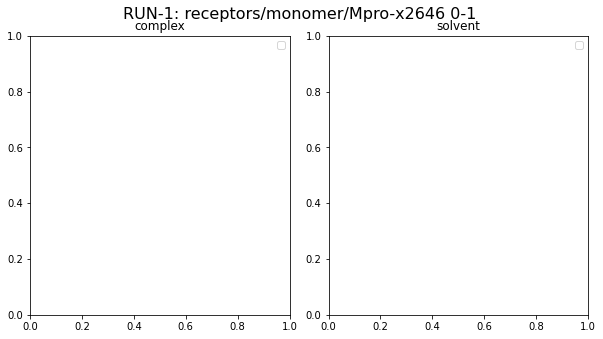


  0%|          | 1/1687 [00:00<09:19,  3.02it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/pymbar/bar.py:373: RuntimeWarning:

invalid value encountered in sqrt

/Users/brucemah/miniconda3/lib/python3.6/site-packages/pymbar/bar.py:373: RuntimeWarning:

invalid value encountered in sqrt

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



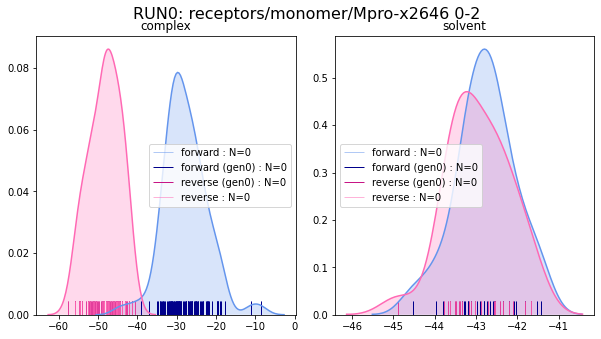


  0%|          | 2/1687 [00:00<11:13,  2.50it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in dou

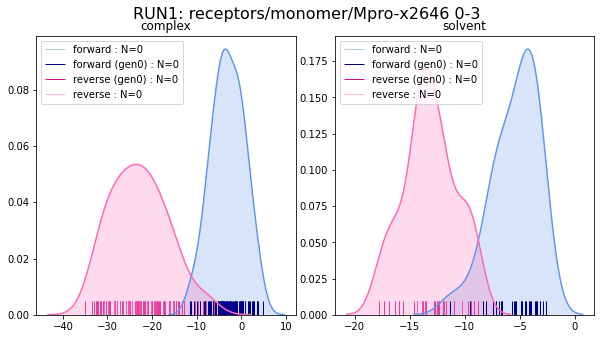


  0%|          | 3/1687 [00:01<12:40,  2.22it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in dou

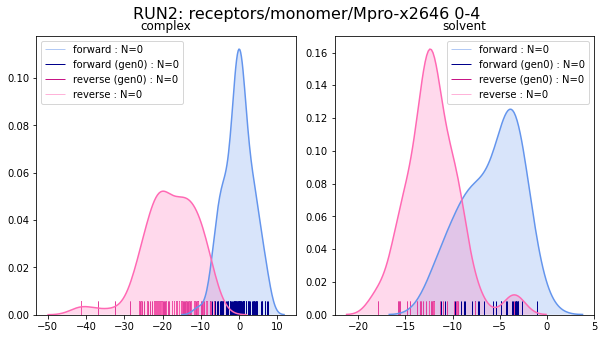


  0%|          | 4/1687 [00:02<13:37,  2.06it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in dou

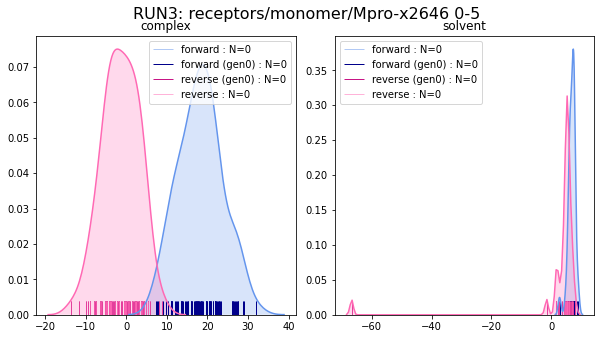


  0%|          | 5/1687 [00:02<14:18,  1.96it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/pymbar/bar.py:373: RuntimeWarning:

invalid value encountered in sqrt

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users

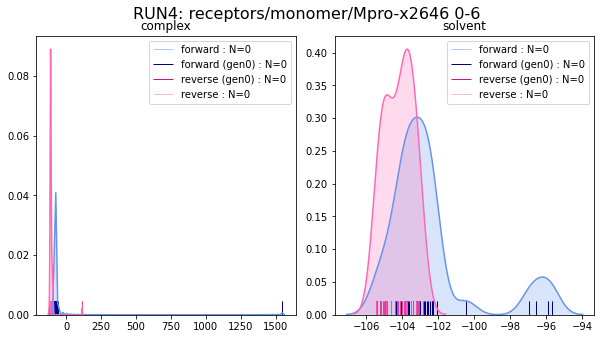


  0%|          | 6/1687 [00:03<14:43,  1.90it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in dou

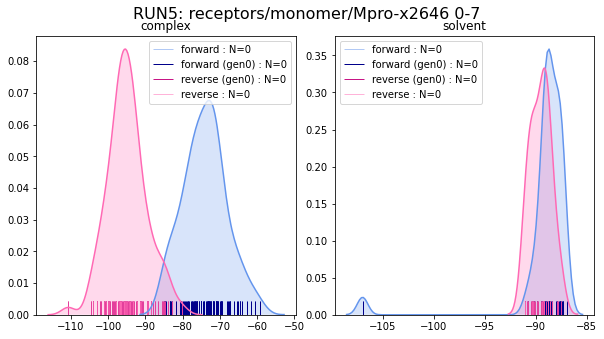


  0%|          | 7/1687 [00:03<15:09,  1.85it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/pymbar/bar.py:373: RuntimeWarning:

invalid value encountered in sqrt

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users

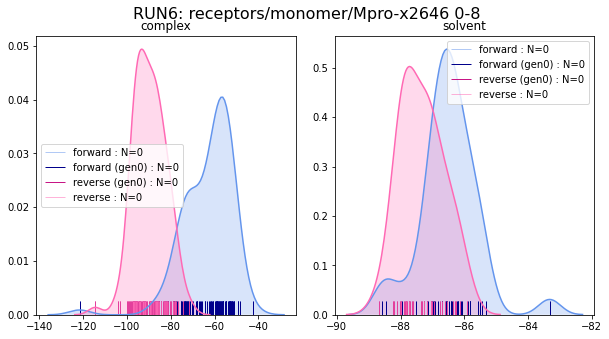


  0%|          | 8/1687 [00:04<16:10,  1.73it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/pymbar/bar.py:373: RuntimeWarning:

invalid value encountered in sqrt

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/pymbar/bar.py:373: RuntimeWarning:

invalid value encountered in sqrt

/Users

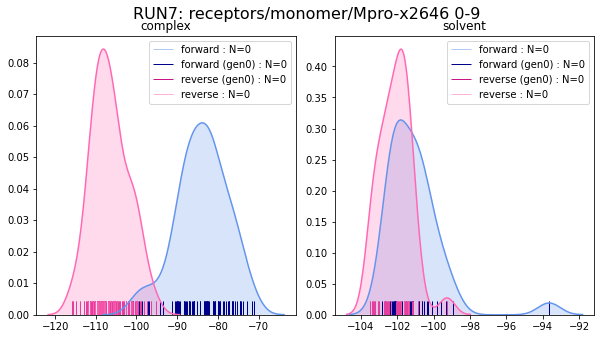


  1%|          | 9/1687 [00:04<16:16,  1.72it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in dou

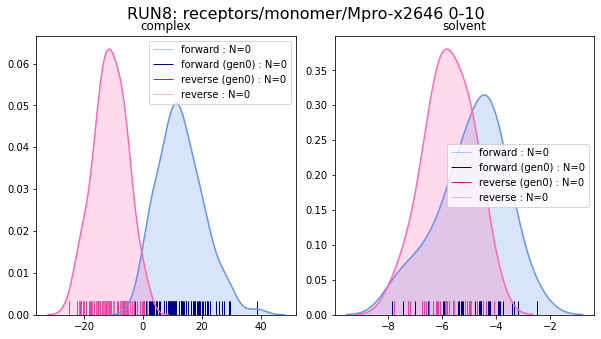


  1%|          | 10/1687 [00:05<16:24,  1.70it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in do

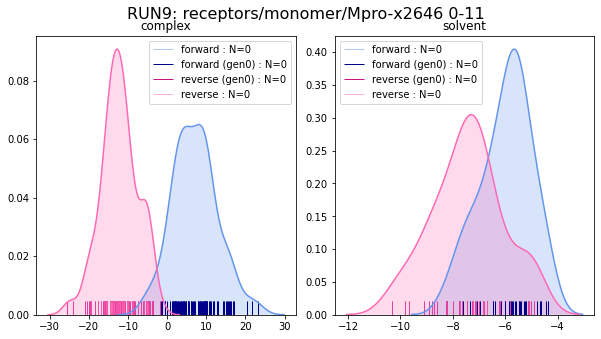


  1%|          | 11/1687 [00:06<16:10,  1.73it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/pymbar/bar.py:373: RuntimeWarning:

invalid value encountered in sqrt

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/User

KeyboardInterrupt: 

In [28]:
projects = {
    'complex' : 'PROJ13420',
    'solvent' : 'PROJ13421'}

import time
plotting = True

def _get_works(df,run,project,GEN=None):
    works = df[(df['RUN']==run)]
    
    if GEN:
        works = works[works['GEN']==GEN]

    f = works[works['PROJ']==project].forward_work
    r = works[works['PROJ']==project].reverse_work   
    return f, r

n_bootstrap = 100
for d in tqdm.tqdm(details.values()):
    RUN = d['directory']
    if plotting:
        fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
    for i, phase in enumerate(projects.keys()):
        if plotting:
            axes[i].set_title(phase)
        
        all_forward = []
        all_reverse = []
        # There will be 6 gens for this project I think
        for gen_id in range(0,7):
            f_works, r_works = _get_works(work,RUN,projects[phase],GEN=f'GEN{gen_id}')
            f_works = _strip_outliers(f_works)       
            r_works = _strip_outliers(r_works)
            d[f'{phase}_fes_GEN{gen_id}'] = []
            d[f'{phase}_dfes_GEN{gen_id}'] = []

            if len(f_works) > 10 and len(r_works) > 10:
                for _ in range(n_bootstrap):
                    f = random.choices(f_works, k=len(f_works))
                    r = random.choices(r_works, k=len(r_works))
                    fe, err = BAR(np.asarray(f), np.asarray(f)) 
                    d[f'{phase}_fes_GEN{gen_id}'].append(fe)
                    d[f'{phase}_dfes_GEN{gen_id}'].append(err)

            all_forward.extend(f_works)
            all_reverse.extend(r_works)
#         print(all_forward)
        if len(all_forward) < 10:
            print(f'Cant calculate {RUN} {phase}')
            continue
        if len(all_reverse) < 10:
            print(f'Cant calculate {RUN} {phase}')
            continue
        if plotting:
            sns.kdeplot(all_forward,shade=True,color='cornflowerblue',ax=axes[i])
            sns.rugplot(all_forward,ax=axes[i],color='cornflowerblue',alpha=0.5,label=f'forward : N={len(f_works)}')
            sns.rugplot(all_forward,ax=axes[i],color='darkblue',label=f'forward (gen0) : N={len(f_works)}')
            sns.rugplot([-x for x in all_reverse],ax=axes[i],color='mediumvioletred',label=f'reverse (gen0) : N={len(r_works)}')
            sns.kdeplot([-x for x in all_reverse],shade=True,color='hotpink',ax=axes[i])
            sns.rugplot([-x for x in all_reverse],ax=axes[i],color='hotpink',alpha=0.5,label=f'reverse : N={len(r_works)}')

        if any([True for x in [all_reverse, all_forward] if len(x) < 20]):
            print(f'Cant calculate {RUN} {phase}')
        else:
            # TODO add bootstrapping here
            d[f'{phase}_fes'] = BAR(np.asarray(all_forward), np.asarray(all_reverse))
#             d[f'n_{phase}'] = len(all_forward) + len(all_reverse)
              
        
    if plotting:    
        fig.suptitle(f"{RUN}: {d['protein'].split('_')[0]} {d['start']}-{d['end']}", fontsize=16)
        fig.subplots_adjust(top=0.9,wspace=0.15)
        axes[0].legend()
        axes[1].legend()
        plt.show()

In [29]:
import networkx as nx


ligand_result = {0:0.}
ligand_result_uncertainty = {0:0.}

for d in details.values():
    if 'complex_fes' in d and 'solvent_fes' in d:
        DDG = ((d['complex_fes'][0] - d['solvent_fes'][0])*kT).value_in_unit(unit.kilocalories_per_mole) 
        dDDG = ((d['solvent_fes'][1]**0.5 + d['complex_fes'][1]**0.5)**2*kT).value_in_unit(unit.kilocalories_per_mole)
        ligand_result[d['end']] = DDG
        ligand_result_uncertainty[d['end']] = DDG

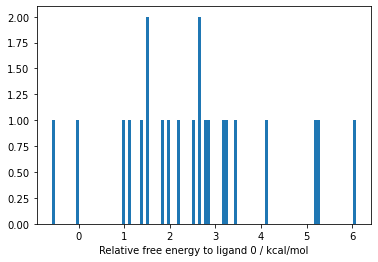

In [30]:
plt.hist(ligand_result.values(),bins=100)
plt.xlabel('Relative free energy to ligand 0 / kcal/mol')
plt.show()

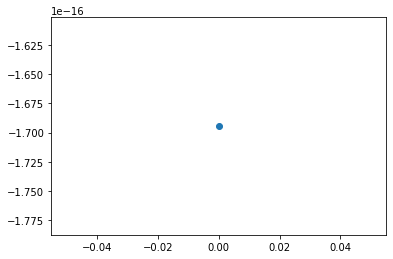

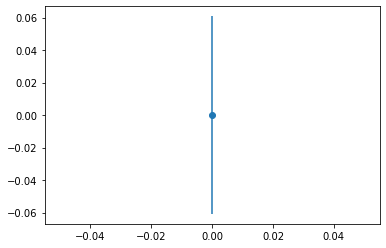

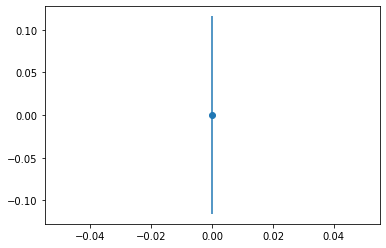

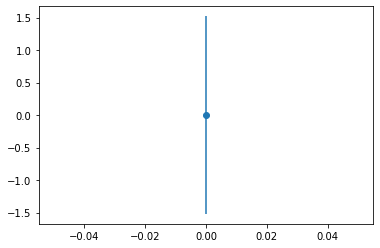

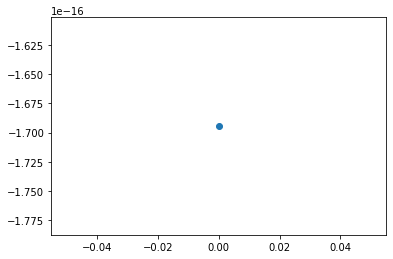

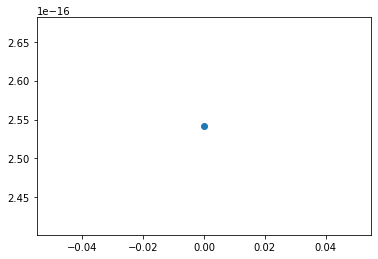

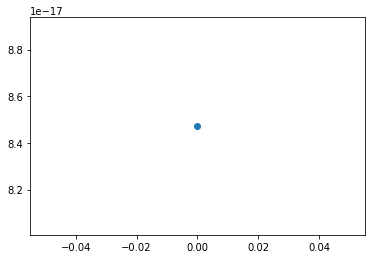

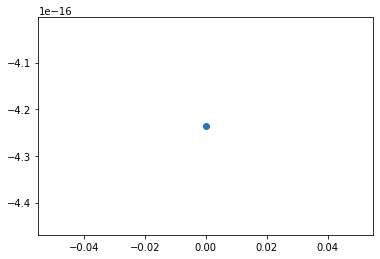

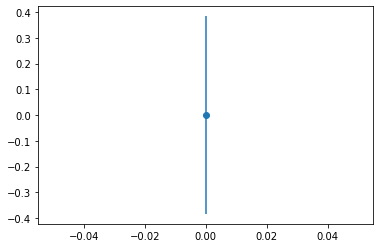

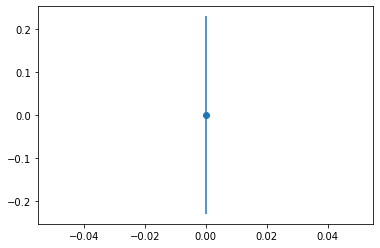

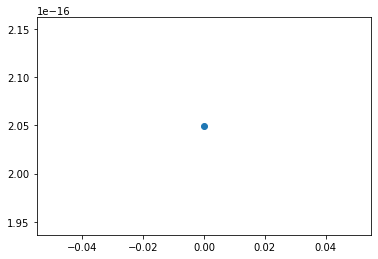

In [35]:
### this will be useful for looking at looking at shift in relative FEs over GENS


for d in details.values():
    if 'complex_fes' in d and 'solvent_fes' in d:
        for i in range(0,7):
            try:
                DDG = ((np.mean(d[f'complex_fes_GEN{i}']) - np.mean(d[f'solvent_fes_GEN{i}']))*kT).value_in_unit(unit.kilocalories_per_mole) 
                dDDG = ((np.mean(d[f'complex_dfes_GEN{i}'])**0.5 + np.mean(d[f'solvent_dfes_GEN{i}'])**0.5)**2*kT).value_in_unit(unit.kilocalories_per_mole)
                plt.errorbar(i, DDG,yerr=dDDG)
                plt.scatter(i,DDG)
            except:
                continue
        plt.show()
